In [1]:
import tensorflow as tf
from tensorflow import keras
import time
import numpy as np

latent_dim = 2
train_size = 60000
batch_size = 32
test_size = 10000
epochs = 10
num_examples_to_generate = 16
optimizer = tf.keras.optimizers.Adam(1e-4)

iterative_pruning_percentage = 0.2 # (0, 1) - percentage of weights to prune between each "pruning iteration"
num_pruning_iterations = 25
rewind_weights = 3 # False|epoch number - reverts weights to initial random initialization or specified epoch

def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

class CVAE(tf.keras.Model):
  """Fully dense variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            #tf.keras.layers.Conv2D(
            #    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            #tf.keras.layers.Conv2D(
            #    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(784),
            tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
            #tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            #tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            #tf.keras.layers.Conv2DTranspose(
            #    filters=64, kernel_size=3, strides=2, padding='same',
            #    activation='relu'),
            #tf.keras.layers.Conv2DTranspose(
            #    filters=32, kernel_size=3, strides=2, padding='same',
            #    activation='relu'),
            # No activation
            #tf.keras.layers.Conv2DTranspose(
            #    filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def _log_normal_pdf(self, sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

  def compute_loss(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    x_logit = self.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = self._log_normal_pdf(z, 0., 0.)
    logqz_x = self._log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)
  
  @tf.function
  def train_step(self, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
      loss = self.compute_loss(x)
    gradients = tape.gradient(loss, self.trainable_variables)
    optimizer.apply_gradients(zip(gradients, self.trainable_variables))


random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
)

cvae = CVAE(latent_dim)

(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images[:100]) #[:100]
            .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images[:100]) #[:100]
            .shuffle(test_size).batch(batch_size))


11490434/11490434 [==============================] - 0s 0us/step


In [2]:
from matplotlib import pyplot as plt

class PruneStats:
  def prune_stats(self, vae, enc_layers, dec_layers, enc_per_layer_masks, dec_per_layer_masks):
    enc_total = 0
    enc_non_zero = 0
    dec_total = 0
    dec_non_zero = 0
    enc_weights = vae.encoder.get_weights()
    dec_weights = vae.decoder.get_weights()

    for layer in enc_layers:
      enc_weights = vae.encoder.get_weights()
      enc_total += enc_weights[layer].shape[0] * enc_weights[layer].shape[1]
      #for j in range(enc_weights[layer].shape[0]):
        #enc_non_zero += enc_weights[layer][j].astype(bool).astype(float).sum()
    
    if len(enc_per_layer_masks) != 0:
      enc_non_zero = enc_total
      for i in range(len(enc_layers)):
        enc_non_zero -= enc_per_layer_masks[i].astype(float).sum()

    for layer in dec_layers:
      dec_weights = vae.decoder.get_weights()
      dec_total += dec_weights[layer].shape[0] * dec_weights[layer].shape[1]
      #for j in range(dec_weights[layer].shape[0]):
        #dec_non_zero += dec_weights[layer][j].astype(bool).astype(float).sum()
    
    if len(dec_per_layer_masks) != 0:
      dec_non_zero = dec_total
      for i in range(len(dec_layers)):
        dec_non_zero -= dec_per_layer_masks[i].astype(float).sum()

    enc_frac = 100.0
    dec_frac = 100.0

    if len(enc_per_layer_masks) == 0:
      print("Encoder | total weights:", enc_total, "non-zero weights:", 100.0, "%.")
      if (len(dec_per_layer_masks) == 0):
        print("Decoder | total weights:", dec_total, "non-zero weights:", 100.0, "%.")
        return 100.0, 100.0
    else:
      enc_frac = round((enc_non_zero / enc_total) * 100, 2)
      print("Encoder | total weights:", enc_total, "non-zero weights:", int(enc_non_zero), enc_frac, "%.")
      if (len(dec_per_layer_masks) == 0):
        print("Decoder | total weights:", dec_total, "non-zero weights:", 100.0, "%.")
        return enc_frac, dec_frac
      dec_frac = round((dec_non_zero / dec_total) * 100, 2)
      print("Decoder | total weights:", dec_total, "non-zero weights:", int(dec_non_zero), dec_frac, "%.")
      return enc_frac, dec_frac
  
  def combine_and_plot(self, caller, pruners):
    num = len(pruners)
    x_epochs = caller.model_eval["x"]
    x_epochs_pruned = caller.model_pruned_eval["x"]
    
    mean_results = caller.model_eval["results"]
    mean_results_time = caller.model_eval["results_time"]
    mean_pruned_results = caller.model_pruned_eval["results"]
    mean_pruned_results_time = caller.model_pruned_eval["results_time"]
    for i in range(num):
      mean_results = np.vstack((mean_results, pruners[i].model_eval["results"]))
      mean_results_time = np.vstack((mean_results_time, pruners[i].model_eval["results_time"]))
      mean_pruned_results = np.vstack((mean_pruned_results, pruners[i].model_pruned_eval["results"]))
      mean_pruned_results_time = np.vstack((mean_pruned_results_time, pruners[i].model_pruned_eval["results_time"]))

    std_results = np.std(mean_results, axis=0)
    std_results_time = np.std(mean_results_time, axis=0)
    std_pruned_results = np.std(mean_pruned_results, axis=0)
    std_pruned_results_time = np.std(mean_pruned_results_time, axis=0)
    mean_results = np.mean(mean_results, axis=0)
    mean_results_time = np.mean(mean_results_time, axis=0)
    mean_pruned_results = np.mean(mean_pruned_results, axis=0)
    mean_pruned_results_time = np.mean(mean_pruned_results_time, axis=0)

    """print("std")
    print(std_results)
    print(mean_results)
    print(std_pruned_results)
    print(mean_pruned_results)
    print()
    print(std_results_time)
    print(mean_results_time)
    print(std_pruned_results_time)
    print(mean_pruned_results_time)
    print()
    print(np.std(mean_results_time))
    print(np.std(mean_pruned_results_time))
    print(np.mean(mean_results_time))
    print(np.mean(mean_pruned_results_time))"""
    
    plt.figure(figsize=(16, 16))
    fig1 = plt.subplot(4, 1, 1)
    plt.errorbar(x_epochs, mean_results, yerr=std_results, fmt="o-", capsize=5)
    plt.title("Unpruned model")
    fig1.invert_yaxis()
    fig1.set_ylabel("ELBO on test dataset")
    fig1.set_xlabel("Epoch")

    fig2 = plt.subplot(4, 1, 2)
    plt.errorbar(x_epochs_pruned, mean_pruned_results, yerr=std_pruned_results, fmt="o-", capsize=5)
    plt.title("Pruned model")
    fig2.invert_yaxis()
    fig2.set_ylabel("ELBO on test dataset")
    fig2.set_xlabel("Epoch")

    fig3 = plt.subplot(4, 1, 3)
    plt.errorbar(x_epochs, mean_results, yerr=std_results, fmt="bo-", capsize=5)
    plt.errorbar(x_epochs_pruned, mean_pruned_results, yerr=std_pruned_results, fmt="ro-", capsize=5)
    plt.legend(["unpruned model", "pruned model"])
    plt.title("Pruned model")
    fig3.invert_yaxis()
    fig3.set_ylabel("ELBO on test dataset")
    fig3.set_xlabel("Epoch")

    fig4 = plt.subplot(4, 1, 4)
    x_all = (np.arange(len(caller.elbo_cache[0]))).astype(int).tolist()
    """print(x_all)
    print(caller.elbo_cache[0])
    print([item.numpy() for item in caller.elbo_cache[0]])
    print("banana")
    print(caller.elbo_cache)"""
    linestyle = "-"
    marker = ["o", "^", "p"]
    colors = ["blue", "red", "yellow", "green", "gold", "cyan", "fuchsia", "plum", "thistle", "cornflowerblue", "bisque", "azure"]
    n_colors = len(colors)
    #legend = [("encoder: " + str(prune_level[0]) + "% | decoder: " + str(prune_level[1]) + "%") for prune_level in pruned_weights_cache] #["encoder: 100.0% | decoder: 100.0%"]
    #legend = legend[:-1]
    for i in range(len(caller.elbo_cache) - 1):
      y = [item.numpy() for item in caller.elbo_cache[i]]
      #print("loop", len(x_all), len(y))
      #print(x_all)
      #print(y)
      plt.plot(x_all, y, linestyle=linestyle, marker=marker[i // n_colors], color=colors[i - ((i // n_colors) * n_colors)])
      #plt.ylim(-162.8, -164.25)
    plt.xlabel("epoch")
    plt.ylabel("elbo")
    plt.title("elbo loss for fully dense VAE for varying number of pruning levels")
    fig4.invert_yaxis()
    #plt.legend(legend, bbox_to_anchor = (1.7, 0.99))

    """fig3 = plt.subplot(4, 1, 4)
    plt.errorbar(x_epochs, mean_results, yerr=std_results, fmt="bo-", capsize=5)
    plt.errorbar(x_epochs_pruned, mean_pruned_results, yerr=std_pruned_results, fmt="ro-", capsize=5)
    plt.legend(["unpruned model", "pruned model"])
    plt.title("Pruned model")
    fig3.invert_yaxis()
    fig3.set_ylabel("ELBO on test dataset")
    fig3.set_xlabel("Epoch")"""

    plt.show()

In [3]:
# Base class - provides common functionality (unstructured prune/weight identification varies):
# structured prune - identification of nodes to prune, and actual pruning of nodes
# creation of new model/layers based on new weight matrices (with old weights)
# restoration of original model that has been pruned in an unstructured manner
# training of models

class Pruner:
  def __init__(self, Model, conf, iterative_pruning_percentage=0.2, num_pruning_iterations=25, rewind_weights=False, enc_mask_dim=(256, 256, 2), dec_mask_dim=(256, 256, 2),\
               original_weights={"encoder": [], "decoder": []}, mask_cache={"encoder": [], "decoder": []}, mask_per_layer_cache={"encoder": [], "decoder": []},\
               elbo_cache=[[] for i in range(num_pruning_iterations)], pruned_weights_cache=[]):
    elbo_cache=[[] for i in range(num_pruning_iterations)]
    self.stats = PruneStats()
    self.Model = Model
    self.iterative_pruning_percentage = iterative_pruning_percentage
    self.num_pruning_iterations = num_pruning_iterations
    self.rewind_weights = rewind_weights
    self.epochs = conf["epochs"]
    #self.epochs = 1
    self.train_dataset = conf["train_dataset"]
    self.test_dataset = conf["test_dataset"]
    self.optimizer = conf["optimizer"]
    self.latent_dim = conf["latent_dim"]
    self.input_shape = conf["input_shape"]
    self.flat_shape = conf["flat_shape"]
    self.prune_encoder = conf["prune_encoder"]
    self.prune_decoder = conf["prune_decoder"]
    self.is_pruned = False
    self.model_pruned = None
    self.model_eval = {"x": [], "results": [], "results_time": []}
    self.model_pruned_eval = {"x": [], "results": [], "results_time": []}
    
    if len(enc_mask_dim) == 3 and type(enc_mask_dim[0]) is int:
      self.enc_mask = np.zeros(enc_mask_dim[0] * enc_mask_dim[1] * enc_mask_dim[2])
      self.enc_mask = self.enc_mask.astype(bool)
      self.prunable_encoder_layers =  enc_mask_dim[2]
    else:
      mask_dim = 0
      for i in range(len(enc_mask_dim)):
        mask_dim += enc_mask_dim[0] * enc_mask_dim[1]
      self.enc_mask = np.zeros(mask_dim)
      self.enc_mask = self.enc_mask.astype(bool)
      self.prunable_encoder_layers = len(enc_mask_dim)

    if len(dec_mask_dim) == 3 and type(dec_mask_dim[0]) is int:
      self.dec_mask = np.zeros(dec_mask_dim[0] * dec_mask_dim[1] * dec_mask_dim[2])
      self.dec_mask = self.dec_mask.astype(bool)
      self.prunable_decoder_layers = dec_mask_dim[2]
    else:
      mask_dim = 0
      for i in range(len(dec_mask_dim)):
        mask_dim += dec_mask_dim[0] * dec_mask_dim[1]
      self.dec_mask = np.zeros(mask_dim)
      self.dec_mask = self.dec_mask.astype(bool)
      self.prunable_decoder_layers = len(dec_mask_dim)

    self.prunable_encoder_index = [2 + (i * 2) for i in range(self.prunable_encoder_layers)]
    self.prunable_decoder_index = [2 + (i * 2) for i in range(self.prunable_decoder_layers)]

    if "num_ensembles" in conf.keys():
      self.original_weights = [original_weights.copy() for i in range(conf["num_ensembles"])]
      self.mask_cache = mask_cache #[mask_cache.copy() for i in range(conf["num_ensembles"])]
      self.mask_per_layer_cache = mask_per_layer_cache #[mask_per_layer_cache.copy() for i in range(conf["num_ensembles"])]
      self.elbo_cache = [elbo_cache.copy() for i in range(conf["num_ensembles"])]
      self.pruned_weights_cache = [pruned_weights_cache.copy() for i in range(conf["num_ensembles"])]
    else:
      self.original_weights = original_weights
      self.mask_cache = mask_cache
      self.mask_per_layer_cache = mask_per_layer_cache
      self.elbo_cache = elbo_cache
      self.pruned_weights_cache = pruned_weights_cache

  # identify prunable nodes - currently based on having 0 weights left, params:
  # model - self explanatory, layers - indices of layers to be pruned, per_layer_masks - prune masks from unstructured prune
  def prunable_units(self, model, layers=[], per_layer_masks=[]):
    weights = model.get_weights()
    num_prunable_weights = 0

    if len(layers) == 0:
      return num_prunable_weights, {}

    prunable_weight_map = {layer: {"map": [], "num": 0} for layer in layers}

    for i, layer in enumerate(layers):
      unit_map = np.invert(np.all(weights[layer], axis=0))
      u_map = np.all(per_layer_masks[i], axis=0)
      prunable_weight_map[layer]["map"] = u_map #unit_map
      total_prunable = u_map.astype(int).sum() #unit_map.astype(int).sum()
      prunable_weight_map[layer]["num"] = total_prunable
      num_prunable_weights += total_prunable

    return num_prunable_weights, prunable_weight_map

  # "physically" removing the weights for the prunable nodes and the corresponding biases, params:
  # model - self explanatory, prunable_layers - indices of layers to be pruned, prune_map - identified nodes with 0 weights, flat_dim - if there is a flatten layer dimensionality of input, 784 for mnist (28x28 input)
  def hard_prune_weights(self, model, prunable_layers, prune_map, flat_dim=False):
    layer_indices = sorted(prune_map.keys())
    weights = model.get_weights()
    weights_all = []
    bias_all = []

    for i, layer in enumerate(prunable_layers):
      indices = np.where(prune_map[layer_indices[i]]["map"])
      w = np.delete(weights[prunable_layers[i]], indices, axis=1)
      b = np.delete(weights[prunable_layers[i] + 1], indices)
      if i > 0:
        row_indices = np.where(prune_map[layer_indices[i - 1]]["map"])
        w = np.delete(w, row_indices, axis=0)
      weights_all.append(w)
      bias_all.append(b)

    last_shape = model.get_weights()[layer].shape[1]
    indices = indices[0]
    if flat_dim:
      final_indices = np.zeros(indices.shape[0] * flat_dim)
      start_index = 0
      end_index = indices.shape[0]
      for i in range(flat_dim):
        final_indices[start_index:end_index] = last_shape * i + indices
        start_index += indices.shape[0]
        end_index += indices.shape[0]
      final_indices = final_indices.astype(int)
    else:
      final_indices = indices

    w = np.delete(weights[prunable_layers[-1] + 2], final_indices, axis=0)

    return weights_all, bias_all, w

  def create_new_layer(self, layer, param, activation="relu", input_shape=None):
    if isinstance(layer, tf.keras.layers.Dense):
      return tf.keras.layers.Dense(param, activation=activation)
    elif isinstance(layer, tf.keras.layers.Flatten):
      return tf.keras.layers.Flatten()
    elif isinstance(layer, tf.keras.layers.Reshape):
      return tf.keras.layers.Reshape(param, input_shape=input_shape)

  def create_model(self, layers):
    return tf.keras.Sequential(layers)

  def store_original_weights(self, model):
    return model.get_weights()

  def unprune_original_model(self):
    if self.is_pruned and self.model_pruned is not None:
      enc_weights = self.original_weights["encoder"][0]
      dec_weights = self.original_weights["decoder"][0]
      self.model.encoder.set_weights(enc_weights)
      self.model.decoder.set_weights(dec_weights)

  def structured_prune_model(self, model, prunable_index, mask_per_layer_cache, flat_dim, input_shape):
    num_prunable_weights, prune_map = self.prunable_units(model, prunable_index, mask_per_layer_cache)
    pruned_weight_matrices, pruned_bias_vectors, final_layer_prune = self.hard_prune_weights(model, prunable_index, prune_map, flat_dim=flat_dim)
    num_layers = len(model.layers)
    layers_to_be_replaced = (np.array(prunable_index) / 2).tolist()
    new_layers = []
    weights = model.get_weights()

    for i, layer in enumerate(prunable_index):
      weights[layer] = pruned_weight_matrices[i]
      weights[layer + 1] = pruned_bias_vectors[i]

    j = 0
    new_layers.append(tf.keras.layers.InputLayer(input_shape=input_shape))
    for i in range(len(model.layers)):
      if i in layers_to_be_replaced:
        new_layers.append(self.create_new_layer(model.layers[i], pruned_weight_matrices[j].shape[1], activation="relu", input_shape=None))
        j += 1
      else:
        param = None
        input_shape = None
        if isinstance(model.layers[i], tf.keras.layers.Dense):
          param = model.layers[i].units
        if isinstance(model.layers[i], tf.keras.layers.Flatten):
          param = self.input_shape
          input_shape = self.flat_shape
        if isinstance(model.layers[i], tf.keras.layers.Reshape):
          param = self.input_shape
          input_shape = self.flat_shape
        new_layers.append(self.create_new_layer(model.layers[i], param, activation="relu", input_shape=input_shape))

    new_model = self.create_model(new_layers)

    j = 0
    for i in range(len(new_model.layers)):
      if i in layers_to_be_replaced:
        weights[i * 2] = pruned_weight_matrices[j]
        weights[i * 2 + 1] = pruned_bias_vectors[j]
        j += 1
      if i == (layers_to_be_replaced[-1] + 1):
        weights[i * 2] = final_layer_prune
    new_model.set_weights(weights)

    return new_model

  def structured_prune(self, replace=False):
    if self.prune_encoder:
      new_encoder = self.structured_prune_model(self.model.encoder, self.prunable_encoder_index, self.mask_per_layer_cache["encoder"][-1], 784, self.input_shape)
    if self.prune_decoder:
      new_decoder = self.structured_prune_model(self.model.decoder, self.prunable_decoder_index, self.mask_per_layer_cache["decoder"][-1], False, self.latent_dim)

    print("ORIGINAL ENCODER")
    print(self.model.encoder.summary())
    if self.prune_encoder:
      print("STRUCTURED PRUNED ENCODER")
      print(new_encoder.summary())
    print()
    print()
    print("ORIGINAL DECODER")
    print(self.model.decoder.summary())
    if self.prune_decoder:
      print("STRUCTURED PRUNED DECODER")
      print(new_decoder.summary())

    if replace:
      self.is_pruned = True
      if self.prune_encoder:
        self.model.encoder = new_encoder
      if self.prune_decoder:
        self.model.decoder = new_decoder
    else:
      self.is_pruned = True
      self.model_pruned = self.Model(self.latent_dim)
      if self.prune_encoder:
        self.model_pruned.encoder = new_encoder
      else:
        self.model_pruned.encoder = self.model.encoder
      if self.prune_decoder:
        self.model_pruned.decoder = new_decoder
      else:
        self.model_pruned.decoder = self.model.decoder

  def train_model(self, epochs, model_pruned=False, eval_every_x_epoch=None):
    if model_pruned:
      model = self.model_pruned
    else:
      model = self.model

    if eval_every_x_epoch is None:
      self.train(model, override_epochs=epochs, pure_train=True)
    else:
      epoch_steps = [eval_every_x_epoch for step in range(epochs // eval_every_x_epoch)]
      if epochs % eval_every_x_epoch != 0:
        epoch_steps.append(epochs % eval_every_x_epoch)

      if model_pruned:
        self.model_pruned_eval["x"] = np.cumsum(epoch_steps)
        eval = self.model_pruned_eval
      else:
        self.model_eval["x"] = np.cumsum(epoch_steps)
        eval = self.model_eval

      for step in epoch_steps:
        self.train(model, override_epochs=step, pure_train=True, eval={"epoch": step, "results": eval["results"], "results_time": eval["results_time"]})

  def train(self, model, pruning_iteration=0, enc_per_layer_masks=[], dec_per_layer_masks=[], original_weights=None, elbo_cache=None, override_epochs=False, pure_train=False, eval=None):
    cvae = model
    if original_weights is None:
      original_weights = self.original_weights
    else:
      original_weights = original_weights

    if elbo_cache is None:
      elbo_cache = self.elbo_cache
    else:
      elbo_cache = elbo_cache

    if not override_epochs:
      epochs = self.epochs
    else:
      epochs = override_epochs

    for epoch in range(1, epochs + 1):
      start_time = time.time()

      for train_x in self.train_dataset:
          cvae.train_step(train_x, self.optimizer)

          if pruning_iteration != 0 and not pure_train:
            enc_weights = cvae.encoder.get_weights()
            dec_weights = cvae.decoder.get_weights()
            
            if self.prune_encoder:
              for i in range(self.prunable_encoder_layers):
                enc_weights[i + 2 + i * 1][enc_per_layer_masks[i]] = 0.0

            if self.prune_decoder:
              for i in range(self.prunable_decoder_layers): 
                dec_weights[i + 2 + i * 1][dec_per_layer_masks[i]] = 0.0
            
            cvae.encoder.set_weights(enc_weights)
            cvae.decoder.set_weights(dec_weights)
            #break

      end_time = time.time()

      loss = tf.keras.metrics.Mean()

      start_time_test = time.time()
      for test_x in self.test_dataset:
          loss(cvae.compute_loss(test_x))
      elbo = -loss.result()
      end_time_test = time.time()
      print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
              .format(epoch, elbo, end_time - start_time))

      if not pure_train or (pure_train and eval is not None):
        if eval is not None:
          eval["results_time"].append(end_time_test - start_time_test)
          if eval["epoch"] == epoch:
            eval["results"].append(elbo.numpy())
        else:
          elbo_cache[pruning_iteration].append(elbo)
      if type(self.rewind_weights) is int and epoch == self.rewind_weights and not pure_train:
        original_weights["encoder"] = original_weights["encoder"][:-1]
        original_weights["decoder"] = original_weights["decoder"][:-1]
        original_weights["encoder"].append(self.store_original_weights(cvae.encoder))
        original_weights["decoder"].append(self.store_original_weights(cvae.decoder))

    return cvae

In [4]:
# Unstructured pruning based on weight magnitude as before
# most of the configuration parameters should be pretty self explanatory, enc_mask_dim and dec_mask_dim which takes dimensionality of prunable layers can either be given in the form below (256, 256, 2)
# which means 256 x 256 and 2 such layers, the same could be expressed as [[256, 256], [256, 256]] (though I haven't had time to test that this works hehe)

class LowMagnitudePruner(Pruner):
  def __init__(self, Model, conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True},\
               iterative_pruning_percentage=0.2, num_pruning_iterations=25, rewind_weights=False, enc_mask_dim=(256, 256, 2), dec_mask_dim=(256, 256, 2)):
    super().__init__(Model, conf, iterative_pruning_percentage, num_pruning_iterations, rewind_weights, enc_mask_dim, dec_mask_dim)
    self.model = Model(conf["latent_dim"])

  # identify weights to prune based on weight magnitude, params:
  # model - model, prune_factor - percentage of weights to prune, mask - one-dimensional representation of pruning masks covering all targeted layers
  def prune_weights(self, model, prune_factor, mask=[]):
    weights = model.get_weights()
    edges = {"h" + str(int(0 + (i / 2))): {"edge_count": weights[i].shape[0] * weights[i].shape[1], "shape": (weights[i].shape[0], weights[i].shape[1])} for i in range(2, len(weights) - 2, 2)}
    w = []

    for i in range(2, len(weights) - 2, 2):
      for j in range(weights[i].shape[0]):
        w += weights[i][j].tolist()

    global_weights = np.array(w)
    global_sorted = np.argsort(np.abs(global_weights))

    to_prune = int(np.floor(prune_factor * (len(global_weights) - np.array(mask).astype(float).sum())))
    i = 0
    pruned = 0
    while True:
      if mask[global_sorted[i]] == True:
        i += 1
        continue

      mask[global_sorted[i]] = True
      pruned += 1
      i += 1

      if pruned == to_prune:
        break

    per_layer_masks = []
    start_index = 0
    end_index = 0
    for i in range(int((len(weights) - 4) / 2)):
      shape = edges["h" + str(int(i + 1))]["shape"]
      shift = shape[0] * shape[1]
      end_index += shift
      per_layer_masks.append((mask[start_index:end_index]).reshape(shape[0], shape[1]))
      start_index += shift
      
    return mask, per_layer_masks

  def unstructured_prune(self):
    enc_per_layer_masks = []
    dec_per_layer_masks = []

    for pruning_iteration in range(self.num_pruning_iterations):
      cvae = self.model
      self.original_weights["encoder"].append(self.store_original_weights(cvae.encoder))
      self.original_weights["decoder"].append(self.store_original_weights(cvae.decoder))

      model = self.train(self.model, pruning_iteration, enc_per_layer_masks, dec_per_layer_masks)
      cvae = model

      print("Pruning iteration", (pruning_iteration + 1), "/", self.num_pruning_iterations)
      enc_prune, dec_prune = self.stats.prune_stats(cvae, [2, 4], [2, 4], enc_per_layer_masks, dec_per_layer_masks)
      self.pruned_weights_cache.append((enc_prune, dec_prune))
      if self.prune_encoder:
        self.enc_mask, enc_per_layer_masks = self.prune_weights(cvae.encoder, iterative_pruning_percentage, self.enc_mask)
        self.mask_cache["encoder"].append(self.enc_mask)
        self.mask_per_layer_cache["encoder"].append(enc_per_layer_masks)
      if self.prune_decoder:
        self.dec_mask, dec_per_layer_masks = self.prune_weights(cvae.decoder, iterative_pruning_percentage, self.dec_mask)
        self.mask_cache["decoder"].append(self.dec_mask)
        self.mask_per_layer_cache["decoder"].append(dec_per_layer_masks)

      cvae.encoder.set_weights(self.original_weights["encoder"][-1])
      cvae.decoder.set_weights(self.original_weights["decoder"][-1])
      
      if self.prune_encoder:
        for j in range(self.prunable_encoder_layers):
          enc_weights = cvae.encoder.get_weights()
          enc_weights[j + 2 + j * 1][enc_per_layer_masks[j]] = 0.0
        cvae.encoder.set_weights(enc_weights)

      if self.prune_decoder:
        for j in range(self.prunable_decoder_layers):
          dec_weights = cvae.decoder.get_weights()
          dec_weights[j + 2 + j * 1][dec_per_layer_masks[j]] = 0.0
        cvae.decoder.set_weights(dec_weights)      
    

In [5]:
# Unstructured pruning based on uncertainty estimation (std of weights of a few ensembles)
# most of the configuration parameters should be pretty self explanatory, enc_mask_dim and dec_mask_dim which takes dimensionality of prunable layers can either be given in the form below (256, 256, 2)
# which means 256 x 256 and 2 such layers, the same could be expressed as [[256, 256], [256, 256]] (though I haven't had time to test that this works hehe)

class UncertaintyPruner(Pruner):
  def __init__(self, Model, conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True, "num_ensembles": 5},\
               iterative_pruning_percentage=0.2, num_pruning_iterations=25, rewind_weights=False, enc_mask_dim=(256, 256, 2), dec_mask_dim=(256, 256, 2)):
    super().__init__(Model, conf, iterative_pruning_percentage, num_pruning_iterations, rewind_weights, enc_mask_dim, dec_mask_dim)
    self.num_ensembles = conf["num_ensembles"]
    self.model = None
    self.models = []

    for i in range(self.num_ensembles):
      self.models.append(Model(conf["latent_dim"]))

  # identify weights to prune based on uncertainty or spread of weights, params:
  # model - model, prune_factor - percentage of weights to prune, mask - one-dimensional representation of pruning masks covering all targeted layers, type - "enc"|"dec" for encoder or decoder
  def prune_weights(self, models, prune_factor, mask=[], type=""):
    if type == "enc":
      models = [model.encoder for model in models]
    elif type == "dec":
      models = [model.decoder for model in models]
    weights = []
    for i in range(self.num_ensembles):
      weights.append(models[i].get_weights())

    edges = {"h" + str(int(0 + (i / 2))): {"edge_count": weights[0][i].shape[0] * weights[0][i].shape[1], "shape": (weights[0][i].shape[0], weights[0][i].shape[1])} for i in range(2, len(weights[0]) - 2, 2)}
    w = []

    for i in range(2, len(weights[0]) - 2, 2):
      for j in range(weights[0][i].shape[0]):
        w_combined = [weights[k][i][j] for k in range(self.num_ensembles)]
        w.append(w_combined)

    global_weights = np.array(w)
    global_sorted = np.std(global_weights, axis=1)
    global_sorted = global_sorted.flatten()
    global_sorted = np.argsort(-global_sorted)

    to_prune = int(np.floor(prune_factor * (global_sorted.shape[0] - np.array(mask).astype(float).sum())))

    i = 0
    pruned = 0
    while True:
      if mask[global_sorted[i]] == True:
        i += 1
        continue

      mask[global_sorted[i]] = True
      pruned += 1
      i += 1

      if pruned == to_prune:
        break

    per_layer_masks = []
    start_index = 0
    end_index = 0
    for i in range(int((len(weights[0]) - 4) / 2)):
      shape = edges["h" + str(int(i + 1))]["shape"]
      shift = shape[0] * shape[1]
      end_index += shift
      per_layer_masks.append((mask[start_index:end_index]).reshape(shape[0], shape[1]))
      start_index += shift

    return mask, per_layer_masks

  def unstructured_prune(self):
    enc_per_layer_masks = []
    dec_per_layer_masks = []

    for pruning_iteration in range(self.num_pruning_iterations):
      for i in range(self.num_ensembles):
        cvae = self.models[i]
        self.original_weights[i]["encoder"].append(self.store_original_weights(cvae.encoder))
        self.original_weights[i]["decoder"].append(self.store_original_weights(cvae.decoder))
      
        model = self.train(self.models[i], pruning_iteration, enc_per_layer_masks, dec_per_layer_masks, self.original_weights[i], self.elbo_cache[i])
        cvae = model

      print("Pruning iteration", (pruning_iteration + 1), "/", self.num_pruning_iterations)
      enc_prune, dec_prune = self.stats.prune_stats(cvae, self.prunable_encoder_index, self.prunable_decoder_index, enc_per_layer_masks, dec_per_layer_masks)
      self.pruned_weights_cache.append((enc_prune, dec_prune))

      if self.prune_encoder:
        self.enc_mask, enc_per_layer_masks = self.prune_weights(self.models, iterative_pruning_percentage, self.enc_mask, "enc")
        self.mask_cache["encoder"].append(self.enc_mask)
        self.mask_per_layer_cache["encoder"].append(enc_per_layer_masks)
      if self.prune_decoder:
        self.dec_mask, dec_per_layer_masks = self.prune_weights(self.models, iterative_pruning_percentage, self.dec_mask, "dec")
        self.mask_cache["decoder"].append(self.dec_mask)
        self.mask_per_layer_cache["decoder"].append(dec_per_layer_masks)

      for i in range(self.num_ensembles):
        cvae = self.models[i]
        cvae.encoder.set_weights(self.original_weights[i]["encoder"][-1])
        cvae.decoder.set_weights(self.original_weights[i]["decoder"][-1])

        if self.prune_encoder:
          for j in range(self.prunable_encoder_layers):
            enc_weights = cvae.encoder.get_weights()
            enc_weights[j + 2 + j * 1][enc_per_layer_masks[j]] = 0.0
          cvae.encoder.set_weights(enc_weights)

        if self.prune_decoder:
          for j in range(self.prunable_decoder_layers):
            dec_weights = cvae.decoder.get_weights()
            dec_weights[j + 2 + j * 1][dec_per_layer_masks[j]] = 0.0
          cvae.decoder.set_weights(dec_weights)

    self.model = self.models[i]

Epoch: 1, Test set ELBO: -542.3360595703125, time elapse for current epoch: 3.232170343399048
Epoch: 2, Test set ELBO: -541.345947265625, time elapse for current epoch: 1.351505994796753
Epoch: 3, Test set ELBO: -539.4244995117188, time elapse for current epoch: 1.4890108108520508
Pruning iteration 1 / 25
Encoder | total weights: 131072 non-zero weights: 100.0 %.
Decoder | total weights: 131072 non-zero weights: 100.0 %.
Epoch: 1, Test set ELBO: -542.2241821289062, time elapse for current epoch: 2.5442638397216797
Epoch: 2, Test set ELBO: -541.1480712890625, time elapse for current epoch: 1.5157296657562256
Epoch: 3, Test set ELBO: -539.540283203125, time elapse for current epoch: 2.5430448055267334
Pruning iteration 2 / 25
Encoder | total weights: 131072 non-zero weights: 104858 80.0 %.
Decoder | total weights: 131072 non-zero weights: 104858 80.0 %.
Epoch: 1, Test set ELBO: -542.2133178710938, time elapse for current epoch: 1.5016059875488281
Epoch: 2, Test set ELBO: -540.94677734375

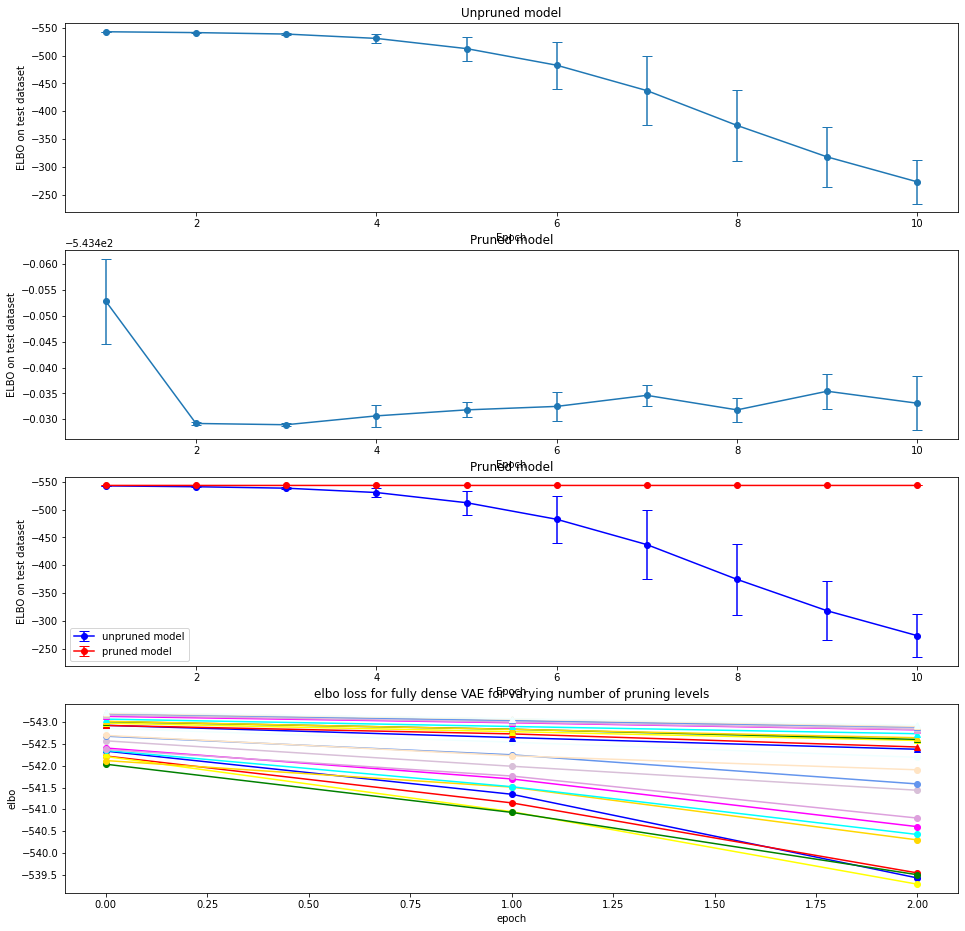

In [6]:
# EXAMPLES

# lowmagnitude conf 
conf={"epochs": 3, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True}
# uncertainty conf 
#conf={"epochs": 10, "optimizer": tf.keras.optimizers.Adam(1e-4), "train_dataset": train_dataset, "test_dataset": test_dataset, "latent_dim": 2, "input_shape": (28, 28, 1), "flat_shape": (784,), "prune_encoder": True, "prune_decoder": True, "num_ensembles": 5}

# example configuration of low magnitude pruning (sole purpose of there being 2 identical pruners only for illustration purposes for the sake of reliable results when do experiments)
# unstructured prune must be run before structured prune as structured prune is based on the masks being created, otherwise to my knowledge should be possible to configure pretty freely although not had time to test run extensively
lm_pruner = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=25)
lm_pruner.unstructured_prune()
lm_pruner.structured_prune()
lm_pruner.train_model(epochs=10, model_pruned=True, eval_every_x_epoch=1)
lm_pruner.unprune_original_model()
lm_pruner.train_model(epochs=10, model_pruned=False, eval_every_x_epoch=1)

lm_pruner2 = LowMagnitudePruner(CVAE, conf, num_pruning_iterations=25)
lm_pruner2.unstructured_prune()
lm_pruner2.structured_prune()
lm_pruner2.train_model(epochs=10, model_pruned=True, eval_every_x_epoch=1)
lm_pruner2.unprune_original_model()
lm_pruner2.train_model(epochs=10, model_pruned=False, eval_every_x_epoch=1)

lm_pruner.stats.combine_and_plot(lm_pruner, [lm_pruner2])

# uncertainty based pruner example
#uncertainty_pruner = UncertaintyPruner(CVAE, conf=conf, num_pruning_iterations=25)
#uncertainty_pruner.unstructured_prune()
#uncertainty_pruner.structured_prune()
#uncertainty_pruner.enforce_train(3)

In [ ]:
# OLD OLD OLD version but functional unstructured pruning

def prune_stats(vae, enc_layers, dec_layers, enc_per_layer_masks, dec_per_layer_masks):
  enc_total = 0
  enc_non_zero = 0
  dec_total = 0
  dec_non_zero = 0
  enc_weights = vae.encoder.get_weights()
  dec_weights = vae.decoder.get_weights()

  for layer in enc_layers:
    enc_weights = vae.encoder.get_weights()
    enc_total += enc_weights[layer].shape[0] * enc_weights[layer].shape[1]
    #for j in range(enc_weights[layer].shape[0]):
      #enc_non_zero += enc_weights[layer][j].astype(bool).astype(float).sum()
  
  if len(enc_per_layer_masks) != 0:
    enc_non_zero = enc_total
    for i in range(len(enc_layers)):
      enc_non_zero -= enc_per_layer_masks[i].astype(float).sum()

  for layer in dec_layers:
    dec_weights = vae.decoder.get_weights()
    dec_total += dec_weights[layer].shape[0] * dec_weights[layer].shape[1]
    #for j in range(dec_weights[layer].shape[0]):
      #dec_non_zero += dec_weights[layer][j].astype(bool).astype(float).sum()
  
  if len(dec_per_layer_masks) != 0:
    dec_non_zero = dec_total
    for i in range(len(dec_layers)):
      dec_non_zero -= dec_per_layer_masks[i].astype(float).sum()

  if len(enc_per_layer_masks) == 0:
    print("Encoder | total weights:", enc_total, "non-zero weights:", 100.0, "%.")
    print("Decoder | total weights:", dec_total, "non-zero weights:", 100.0, "%.")
    return 100.0, 100.0

  print("Encoder | total weights:", enc_total, "non-zero weights:", int(enc_non_zero), (enc_non_zero / enc_total) * 100, "%.")
  print("Decoder | total weights:", dec_total, "non-zero weights:", int(dec_non_zero), (dec_non_zero / dec_total) * 100, "%.")
  return round((enc_non_zero / enc_total) * 100, 2), round((dec_non_zero / dec_total) * 100, 2)

def prunable_units(model, layers=[], per_layer_masks=[]):
  weights = model.get_weights()
  num_prunable_weights = 0

  if len(layers) == 0:
    return num_prunable_weights, {}

  prunable_weight_map = {layer: {"map": [], num: 0} for layer in layers}

  for i, layer in enumerate(layers):
    unit_map = np.invert(np.all(weights[layer], axis=0))
    prunable_weight_map[layer]["map"] = unit_map
    total_prunable = unit_map.astype(int).sum()
    prunable_weight_map[layer]["num"] = total_prunable
    num_prunable_weights += total_prunable

  return num_prunable_weights, prunable_weight_map

def store_original_weights(model):
  return model.get_weights()

def prune_weights(model, prune_factor, mask=[], nma=""):
  weights = model.get_weights()
  edges = {"h" + str(int(0 + (i / 2))): {"edge_count": weights[i].shape[0] * weights[i].shape[1], "shape": (weights[i].shape[0], weights[i].shape[1])} for i in range(2, len(weights) - 2, 2)}
  w = []

  for i in range(2, len(weights) - 2, 2):
    for j in range(weights[i].shape[0]):
      w += weights[i][j].tolist()

  global_weights = np.array(w)
  global_sorted = np.argsort(np.abs(global_weights))

  to_prune = int(np.floor(prune_factor * (len(global_weights) - np.array(mask).astype(float).sum())))
  i = 0
  pruned = 0
  while True:
    if mask[global_sorted[i]] == True:
      i += 1
      continue

    mask[global_sorted[i]] = True
    pruned += 1
    i += 1

    if pruned == to_prune:
      break

  per_layer_masks = []
  start_index = 0
  end_index = 0
  for i in range(int((len(weights) - 4) / 2)):
    shape = edges["h" + str(int(i + 1))]["shape"]
    shift = shape[0] * shape[1]
    end_index += shift
    per_layer_masks.append((mask[start_index:end_index]).reshape(shape[0], shape[1]))
    start_index += shift
    
  return mask, per_layer_masks

In [ ]:
# OLD OLD OLD version but functional unstructured pruning

enc_mask = np.zeros(256**2*2)
dec_mask = np.zeros(256**2*2)
enc_mask = enc_mask.astype(bool)
dec_mask = dec_mask.astype(bool)
original_weights = {"encoder": [], "decoder": []}
mask_cache = {"encoder": [], "decoder": []}
mask_per_layer_cache = {"encoder": [], "decoder": []}
prunable_encoder_layers = 2
prunable_decoder_layers = 2
enc_per_layer_masks = []
dec_per_layer_masks = []
elbo_cache = [[] for i in range(num_pruning_iterations)]
pruned_weights_cache = []

print("BEFORE TRAIN", enc_mask.astype(float).sum(), dec_mask.astype(float).sum())

for pruning_iteration in range(num_pruning_iterations):
  original_weights["encoder"].append(store_original_weights(cvae.encoder))
  original_weights["decoder"].append(store_original_weights(cvae.decoder))

  for epoch in range(1, epochs + 1):
    start_time = time.time()

    for train_x in train_dataset:
        cvae.train_step(train_x, optimizer)
        
        if pruning_iteration != 0:
          enc_weights = cvae.encoder.get_weights()
          dec_weights = cvae.decoder.get_weights()
          
          for i in range(prunable_encoder_layers): 
            enc_weights[i + 2 + i * 1][enc_per_layer_masks[i]] = 0.0

          for i in range(prunable_decoder_layers): 
            dec_weights[i + 2 + i * 1][dec_per_layer_masks[i]] = 0.0
          
          cvae.encoder.set_weights(enc_weights)
          cvae.decoder.set_weights(dec_weights)

    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(cvae.compute_loss(test_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
            .format(epoch, elbo, end_time - start_time))
    elbo_cache[pruning_iteration].append(elbo)
    if type(rewind_weights) is int and epoch == rewind_weights:
      original_weights["encoder"] = original_weights["encoder"][:-1]
      original_weights["decoder"] = original_weights["decoder"][:-1]
      original_weights["encoder"].append(store_original_weights(cvae.encoder))
      original_weights["decoder"].append(store_original_weights(cvae.decoder))

  #print("len", len(mask_cache["encoder"][-1]), (np.array(mask_cache["encoder"][-1])).astype(float).sum())
  print("Pruning iteration", (pruning_iteration + 1), "/", num_pruning_iterations)
  enc_prune, dec_prune = prune_stats(cvae, [2, 4], [2, 4], enc_per_layer_masks, dec_per_layer_masks)
  pruned_weights_cache.append((enc_prune, dec_prune))

  enc_mask, enc_per_layer_masks = prune_weights(cvae.encoder, iterative_pruning_percentage, enc_mask, "enc")
  mask_cache["encoder"].append(enc_mask)
  mask_per_layer_cache["encoder"].append(enc_per_layer_masks)
  dec_mask, dec_per_layer_masks = prune_weights(cvae.decoder, iterative_pruning_percentage, dec_mask, "dec")
  mask_cache["decoder"].append(dec_mask)
  mask_per_layer_cache["decoder"].append(dec_per_layer_masks)
  cvae.encoder.set_weights(original_weights["encoder"][-1])
  cvae.decoder.set_weights(original_weights["decoder"][-1])
  for i in range(prunable_encoder_layers):
    enc_weights = cvae.encoder.get_weights()
    enc_weights[i + 2 + i * 1][enc_per_layer_masks[i]] = 0.0

  for i in range(prunable_decoder_layers):
    dec_weights = cvae.decoder.get_weights()
    dec_weights[i + 2 + i * 1][dec_per_layer_masks[i]] = 0.0

  cvae.encoder.set_weights(enc_weights)
  cvae.decoder.set_weights(dec_weights)

BEFORE TRAIN 0.0 0.0
Epoch: 1, Test set ELBO: -181.26300048828125, time elapse for current epoch: 21.430744647979736
Epoch: 2, Test set ELBO: -172.7793731689453, time elapse for current epoch: 20.782392740249634
Epoch: 3, Test set ELBO: -170.7410430908203, time elapse for current epoch: 20.819172382354736
Epoch: 4, Test set ELBO: -169.40664672851562, time elapse for current epoch: 20.82560086250305
Epoch: 5, Test set ELBO: -168.11790466308594, time elapse for current epoch: 20.878944635391235
Epoch: 6, Test set ELBO: -167.306884765625, time elapse for current epoch: 20.920922994613647
Epoch: 7, Test set ELBO: -166.88711547851562, time elapse for current epoch: 20.96376895904541
Epoch: 8, Test set ELBO: -166.53921508789062, time elapse for current epoch: 20.954233646392822
Epoch: 9, Test set ELBO: -166.24192810058594, time elapse for current epoch: 20.9282283782959
Epoch: 10, Test set ELBO: -165.92189025878906, time elapse for current epoch: 20.897180318832397
Pruning iteration 1 / 25
E

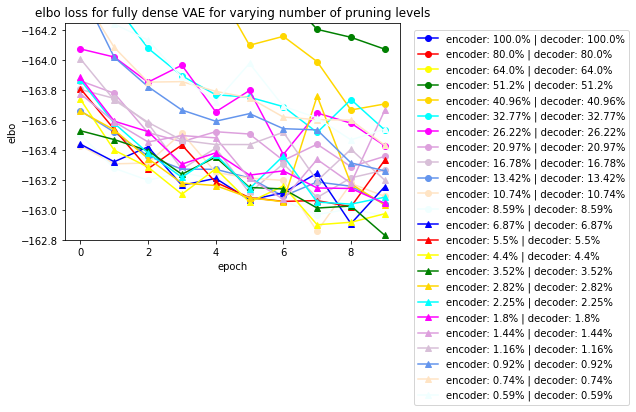

In [ ]:
from matplotlib import pyplot as plt

x_all = np.arange(epochs).tolist()
linestyle = "-"
marker = ["o", "^", "p"]
colors = ["blue", "red", "yellow", "green", "gold", "cyan", "fuchsia", "plum", "thistle", "cornflowerblue", "bisque", "azure"]
n_colors = 12
legend = [("encoder: " + str(prune_level[0]) + "% | decoder: " + str(prune_level[1]) + "%") for prune_level in pruned_weights_cache] #["encoder: 100.0% | decoder: 100.0%"]
legend = legend[:-1]
for i in range(num_pruning_iterations - 1):
  plt.plot(x_all, elbo_cache[i], linestyle=linestyle, marker=marker[i // n_colors], color=colors[i - ((i // n_colors) * n_colors)])
  plt.ylim(-162.8, -164.25)
plt.xlabel("epoch")
plt.ylabel("elbo")
plt.title("elbo loss for fully dense VAE for varying number of pruning levels")
plt.legend(legend, bbox_to_anchor = (1.7, 0.99))
plt.show()